In [1]:
from numpy.random import binomial

import random
import math
from functools import reduce

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score
from multiprocessing import Pool
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import itertools

from post_crisis_monitoring.data_generation.generate_data import get_weekly_crisis, get_time_since_last_event
from post_crisis_monitoring.utils import initial_state_probabilities, safe_division
from post_crisis_monitoring.visualization.plot_histogram_percentage import plot_histogram_percentage
from post_crisis_monitoring.visualization.plot_error_distribution import plot_error_distribution
from post_crisis_monitoring.visualization.plot_confusion_matrix import plot_confusion_matrix
from post_crisis_monitoring.visualization.plot_iteration_convergence import plot_iteration_convergence
from post_crisis_monitoring.parameter_estimation.baum_welch_algorithm import compute_baum_welch_values
from post_crisis_monitoring.parameter_estimation.estimate_patient_hmm_params import estimate_patient_hmm_params, get_estimated_patients_hmm_params
from post_crisis_monitoring.model_evaluation.compute_expected_value_crisis import compute_expected_value_crisis


pd.set_option('display.max_rows', 100)

tqdm.pandas()

In [3]:
data, hospital = get_weekly_crisis(num_patients=3000, weeks=52*5, seed=77)

In [4]:
hospital.patients[0].parameters

{'initial_state': 0,
 'internal_variable_dict': {'G': 0.5, 'B': -0.5},
 'prob_crisis_dict': {'G': 0, 'B': 0.9684901865985973},
 'prob_observe_state_dict': {'G': 0, 'B': 0},
 'transition_variables': {'q_GB': 0.09079796712050256,
  'q_BB': 0.24745730750025585}}

In [5]:
def get_patient_params(patient):
    patient_params = {
    'patient': patient.name, 
    'q': patient.parameters.get('transition_variables', {}).get('q_GB'),
    'r': patient.parameters.get('transition_variables', {}).get('q_BB'),
    'p': patient.parameters.get('prob_crisis_dict', {}).get('B'),
    'prob_observe_state': patient.parameters.get('prob_observe_state_dict', {}).get('G'),   
    }
    return patient_params

patients_params = pd.DataFrame([get_patient_params(patient) for patient in hospital.patients])

In [6]:
patients_params['pat_id'] = patients_params['patient'].copy()

In [ ]:
data = data.reset_index(drop=True)
data['pat_id'] = data['patient'].copy()
data['crisis_max'] = data['crisis'].copy()
data['time_since_last_crisis'] = data.groupby('patient')['crisis'].progress_apply(get_time_since_last_event)
data['time_since_last_crisis'] = data['time_since_last_crisis'] + 1

train_data = data[data['week'] < 200]
test_data = data[data['week'] >= 200]


In [8]:
initial_hmm_params = {
    'p': 0.9,
    'q': 0.2,
    'r': 0.8,
}

initial_hmm_params['p_x0'] = initial_state_probabilities(initial_hmm_params['q'], initial_hmm_params['r'])

In [9]:
pool = Pool(8)
estimated_hmm_params = get_estimated_patients_hmm_params(train_data, num_iter=1000, tol=1e-5, 
                                                         initial_hmm_params=initial_hmm_params,
                                                         pool=pool)
pool.terminate()
estimated_hmm_params['q'] = np.floor(estimated_hmm_params['q'] * 100000) / 100000
estimated_hmm_params['r'] = np.floor(estimated_hmm_params['r'] * 100000) / 100000
estimated_hmm_params['p'] = np.floor(estimated_hmm_params['p'] * 100000) / 100000

  0%|          | 0/3000 [00:00<?, ?it/s]

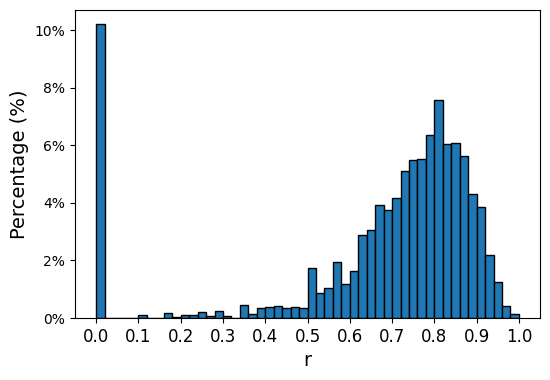

In [11]:
plot_histogram_percentage(estimated_hmm_params, 'r', np.round(np.linspace(0,1, 11), decimals=1))

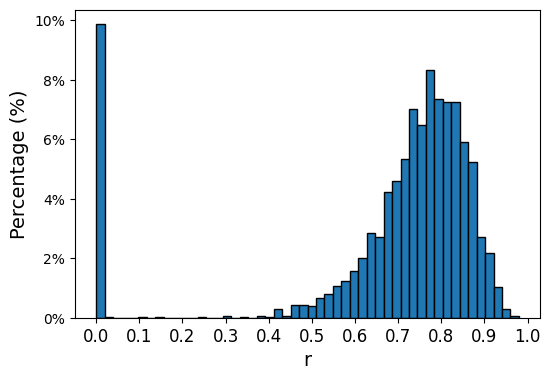

In [12]:
plot_histogram_percentage(patients_params, 'r', np.round(np.linspace(0,1, 11), decimals=1))

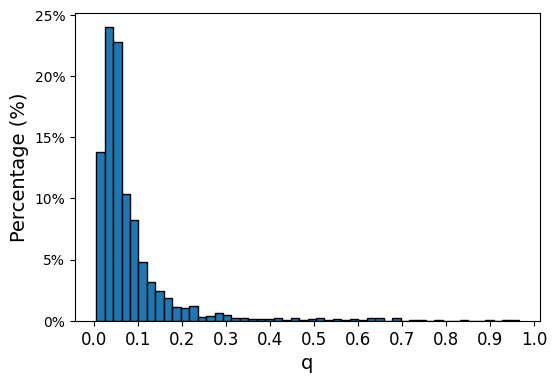

In [13]:
plot_histogram_percentage(estimated_hmm_params, 'q', np.round(np.linspace(0,1, 11), decimals=1))

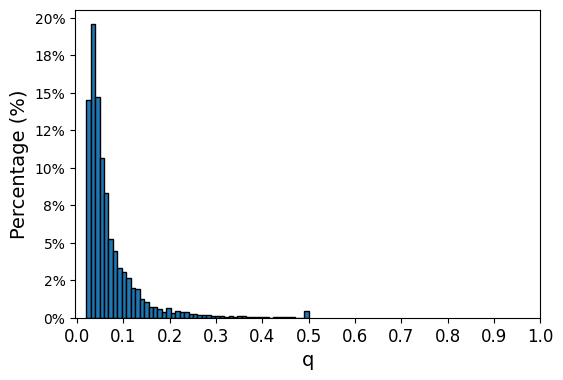

In [14]:
plot_histogram_percentage(patients_params, 'q', np.round(np.linspace(0,1, 11), decimals=1))

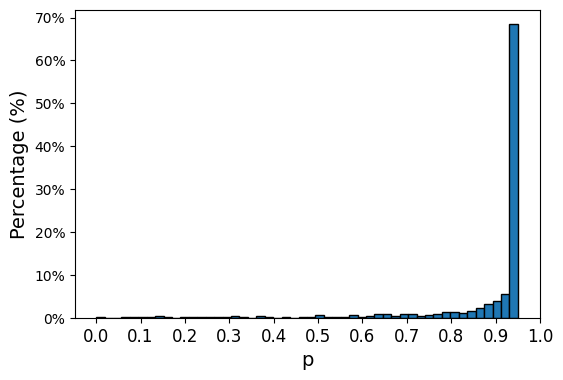

In [15]:
plot_histogram_percentage(estimated_hmm_params, 'p', np.round(np.linspace(0,1, 11), decimals=1))

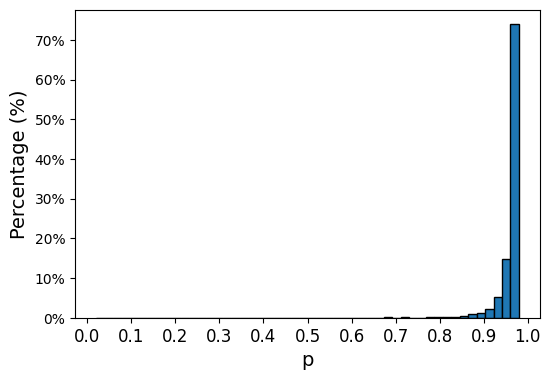

In [16]:
plot_histogram_percentage(patients_params, 'p', np.round(np.linspace(0,1, 11), decimals=1))

In [17]:
estimated_hmm_params = pd.merge(patients_params, estimated_hmm_params.rename(columns={'q': 'q_est', 'r': 'r_est', 'p': 'p_est'}), on='pat_id', how='inner')

estimated_hmm_params['q_err'] = estimated_hmm_params['q_est'] - estimated_hmm_params['q']
estimated_hmm_params['r_err'] = estimated_hmm_params['r_est'] - estimated_hmm_params['r']
estimated_hmm_params['p_err'] = estimated_hmm_params['p_est'] - estimated_hmm_params['p']


estimated_hmm_params['q_abs_err'] = np.abs(estimated_hmm_params['q'] - estimated_hmm_params['q_est'])
estimated_hmm_params['r_abs_err'] = np.abs(estimated_hmm_params['r'] - estimated_hmm_params['r_est'])
estimated_hmm_params['p_abs_err'] = np.abs(estimated_hmm_params['p'] - estimated_hmm_params['p_est'])

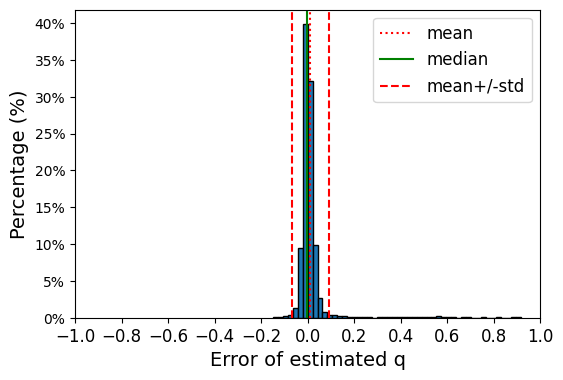

In [18]:
plot_error_distribution(estimated_hmm_params, 'q_err', xlabel='Error of estimated q', xticks=np.round(np.linspace(-1,1, 11), decimals=1))

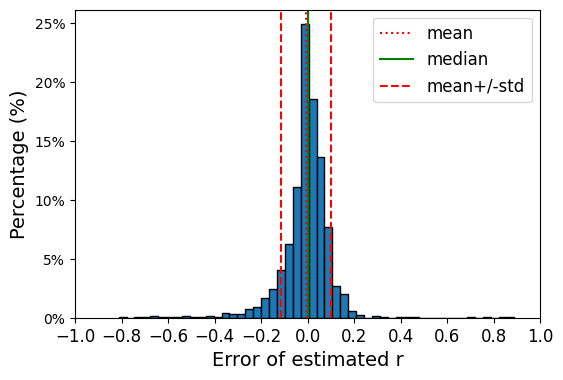

In [19]:
plot_error_distribution(estimated_hmm_params, 'r_err', xlabel='Error of estimated r', xticks=np.round(np.linspace(-1,1, 11), decimals=1))

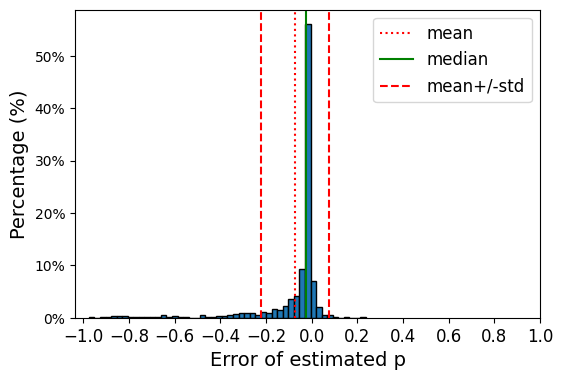

In [20]:
plot_error_distribution(estimated_hmm_params, 'p_err', xlabel='Error of estimated p', xticks=np.round(np.linspace(-1,1, 11), decimals=1))

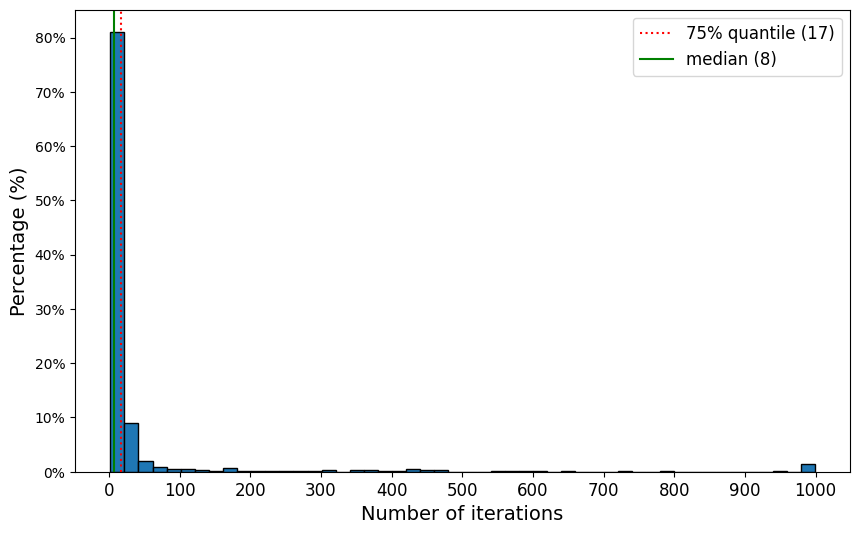

In [22]:
plot_iteration_convergence(estimated_hmm_params, 'iteration_convergence', xticks=list(range(0, 1001,100)))

In [23]:
(estimated_hmm_params['iteration_convergence'] < 999).mean()

0.9853333333333333

In [24]:
(estimated_hmm_params['iteration_convergence'] <= 50).mean()


0.9136666666666666

In [25]:
estimated_hmm_params.describe()[[col for col in estimated_hmm_params.columns if '_err' in col]]

,q_err,r_err,p_err,q_abs_err,r_abs_err,p_abs_err
count,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000
mean,0.012059,-0.007269,-0.074090,2.735973e-02,0.064385,0.078512
std,0.078962,0.106500,0.148831,7.504461e-02,0.085136,0.146545
min,-0.148810,-0.812542,-0.975687,8.867470e-07,0.000000,0.000030
25%,-0.011798,-0.041112,-0.050475,5.929984e-03,0.015610,0.019545
50%,-0.000268,0.000000,-0.026254,1.247249e-02,0.042355,0.026692
75%,0.013269,0.043697,-0.017877,2.305913e-02,0.082515,0.055373
max,0.916711,0.890090,0.237703,9.167106e-01,0.890090,0.975687


In [26]:
test_data = pd.merge(test_data, estimated_hmm_params, on='patient', how='inner')
test_data['prediction'] = test_data.apply(lambda row: compute_expected_value_crisis(row['p_est'], row['q_est'], row['r_est'], row['time_since_last_crisis'], 'B'), axis=1)
test_data['target'] = test_data.groupby('patient')['crisis'].shift(-1)
data_to_evaluate = test_data[['patient', 'week', 'target', 'prediction', 'p_est', 'q_est', 'r_est', 'p', 'q', 'r']].dropna()


0.3484848484848485


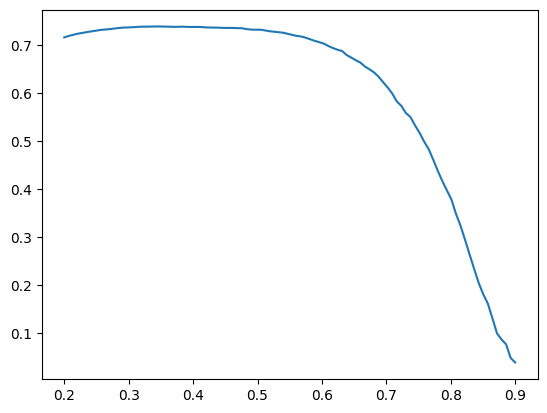

In [37]:
policy_thresholds = np.linspace(0.2, 0.9, 100)

metric_f1_scores = []
for thresh in policy_thresholds:
    test_data['binary_pred'] = test_data['prediction'] > thresh
    metric_f1_scores.append(f1_score(y_true=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()), 'target'],
                                     y_pred=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()), 'binary_pred']))

print(policy_thresholds[np.argmax(metric_f1_scores)])
plt.plot(policy_thresholds, metric_f1_scores)
plt.show()

In [38]:
max(metric_f1_scores)

0.7394009022893492

In [39]:
print(policy_thresholds[np.argmax(metric_f1_scores)])

0.3484848484848485


In [33]:
policy_threshold = 0.35

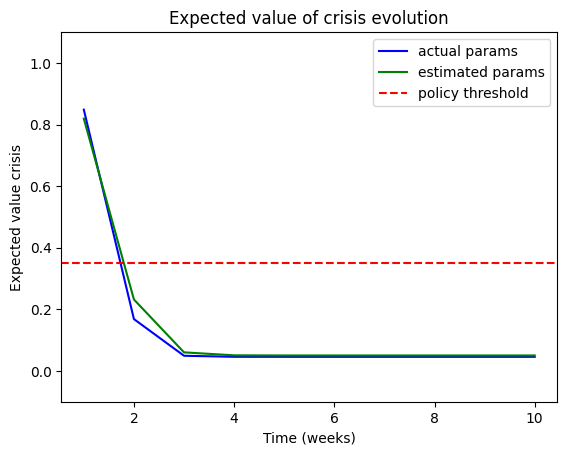

In [34]:
patient = random.choice(estimated_hmm_params['pat_id'])
parameters_patient = estimated_hmm_params[estimated_hmm_params['pat_id'] == patient].iloc[0].to_dict()
max_value = 10
expected_values_est = []
expected_values_real = []
for t in range(1, max_value+1):
    expected_values_est.append(compute_expected_value_crisis(parameters_patient['p_est'], parameters_patient['q_est'], 
                                                                        parameters_patient['r_est'], t, 'B'))
    expected_values_real.append(compute_expected_value_crisis(parameters_patient['p'], parameters_patient['q'], 
                                                                        parameters_patient['r'], t, 'B'))
plt.figure()
plt.plot(list(range(1, max_value+1)), expected_values_real, label=f'actual params', color='b')
plt.plot(list(range(1, max_value+1)), expected_values_est, label=f'estimated params', color='g')
plt.axhline(y=policy_threshold, color='r', linestyle='--', label='policy threshold')
plt.ylim((-0.1, 1.1))
plt.legend()
plt.xlabel('Time (weeks)')
plt.ylabel('Expected value crisis')
plt.title('Expected value of crisis evolution')
plt.show()

In [35]:
max_value = 50
for t in range(1, max_value+1):
    estimated_hmm_params[f'risk_after_{t}_weeks'] = estimated_hmm_params.apply(
        lambda row: compute_expected_value_crisis(row['p_est'], row['q_est'],
                                                  row['r_est'], t, 'B'), axis=1)

In [40]:
max_iterations = 200
week_stable_patient = []
for patient in test_data['patient'].unique():
    patient_params = test_data[test_data['patient'] == patient].iloc[0][['q_est', 'r_est', 'p_est',]].to_dict()
    for t in range(1, max_iterations+2):
        risk_crisis = compute_expected_value_crisis(patient_params['p_est'], patient_params['q_est'], patient_params['r_est'], t, 'B')
        if risk_crisis < policy_threshold:
            break
    week_stable_patient.append({'patient': patient, **patient_params, 'week_start_stable': t})
num_weeks_monitoring_per_patient = pd.DataFrame(week_stable_patient)

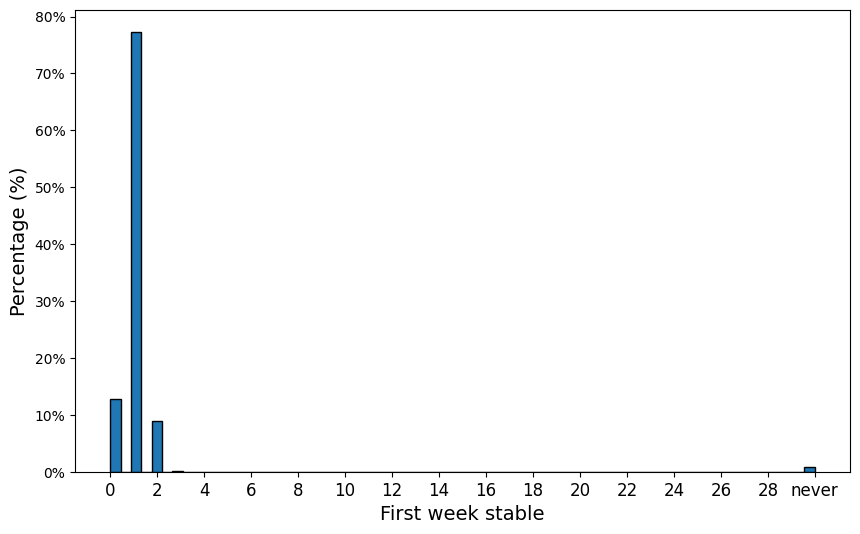

In [41]:

plt.figure(figsize=(10,6))
plt.hist(np.clip(num_weeks_monitoring_per_patient['week_start_stable']-1, 0, 30), weights=np.ones(len(num_weeks_monitoring_per_patient['week_start_stable'])) / len(num_weeks_monitoring_per_patient), 
         edgecolor='black', bins=68, label='')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('First week stable', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(ticks=list(range(0, 31,2)), labels = list(range(0, 31,2))[:-1]+['never'], fontsize=12)
#plt.savefig('../paper/sim_first_week_stable_distr.tiff', bbox_inches='tight', format='tiff',dpi=400)
plt.show()

In [42]:
(num_weeks_monitoring_per_patient['week_start_stable']-1).value_counts().sort_values(ascending=False) / len(num_weeks_monitoring_per_patient)

1      0.773333
0      0.127000
2      0.089667
200    0.007667
3      0.001333
6      0.000333
15     0.000333
5      0.000333
Name: week_start_stable, dtype: float64

In [43]:
data_to_evaluate_monitoring = pd.merge(test_data, num_weeks_monitoring_per_patient[['patient', 'week_start_stable']], on='patient')
data_to_evaluate_monitoring['week_start_stable'] = data_to_evaluate_monitoring['week_start_stable'].fillna(1000)
data_to_evaluate_monitoring['monitoring'] = data_to_evaluate_monitoring['time_since_last_crisis'] < data_to_evaluate_monitoring['week_start_stable']
data_to_evaluate_monitoring['unstable'] = data_to_evaluate_monitoring['internal_state'] == 'B'

In [44]:
data_to_evaluate_monitoring['weeks_after_stable'] = data_to_evaluate_monitoring['time_since_last_crisis']-data_to_evaluate_monitoring['week_start_stable']

weeks_after_stable = [-1]
perc_unstable = [data_to_evaluate_monitoring[(data_to_evaluate_monitoring['time_since_last_crisis'] < data_to_evaluate_monitoring['week_start_stable'])]['unstable'].mean()]
for t in list(range(0, 10)):
    perc_unstable.append(data_to_evaluate_monitoring[(data_to_evaluate_monitoring['time_since_last_crisis'] == data_to_evaluate_monitoring['week_start_stable']+t)]['unstable'].mean())
    weeks_after_stable.append(t)
perc_unstable.append(data_to_evaluate_monitoring[(data_to_evaluate_monitoring['time_since_last_crisis'] >= data_to_evaluate_monitoring['week_start_stable']+t)]['unstable'].mean())
weeks_after_stable.append(t+1)

In [45]:
perc_unstable

[0.9618091006926239,
 0.25082402977139817,
 0.008213292898660601,
 0.004775951678606546,
 0.00462178400862733,
 0.0036734012355985972,
 0.0035790980672870437,
 0.0019241870309794113,
 0.003917525773195876,
 0.0019836896627727575,
 0.0025858015984955335,
 0.0021826244615615583]

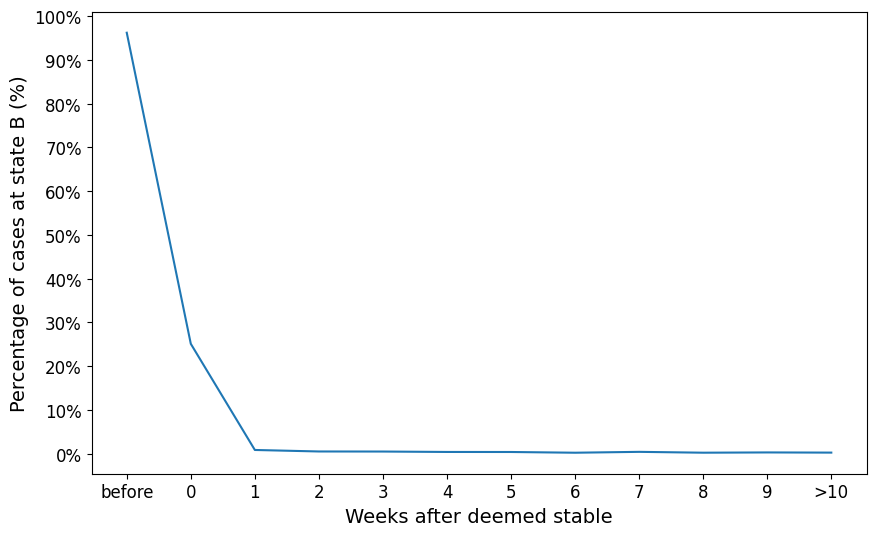

In [47]:
plt.figure(figsize=(10,6))
plt.plot(weeks_after_stable, perc_unstable)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Weeks after deemed stable', fontsize=14)
plt.ylabel('Percentage of cases at state B (%)', fontsize=14)
plt.yticks([perc / 100 for perc in range(0,101, 10)], fontsize=12)
plt.xticks(weeks_after_stable, labels=['before']+weeks_after_stable[1:-1]+['>10'], fontsize=12)
#plt.savefig('../paper/sim_perc_b_states_after_stable.tiff', bbox_inches='tight', format='tiff',dpi=400)
plt.show()

In [48]:
data_to_evaluate_monitoring['weeks_after_stable'] = data_to_evaluate_monitoring['time_since_last_crisis']-data_to_evaluate_monitoring['week_start_stable']

weeks_after_stable = [-1]
perc_unstable = [data_to_evaluate_monitoring[(data_to_evaluate_monitoring['time_since_last_crisis'] < data_to_evaluate_monitoring['week_start_stable'])]['unstable'].mean()]
for t in list(range(0, 10)):
    perc_unstable.append(data_to_evaluate_monitoring[(data_to_evaluate_monitoring['time_since_last_crisis'] <= data_to_evaluate_monitoring['week_start_stable']+t)]['unstable'].mean())
    weeks_after_stable.append(t)
perc_unstable.append(data_to_evaluate_monitoring[(data_to_evaluate_monitoring['time_since_last_crisis'] >= data_to_evaluate_monitoring['week_start_stable']+t)]['unstable'].mean())
weeks_after_stable.append(t+1)

In [49]:
perc_unstable

[0.9618091006926239,
 0.8153097888002804,
 0.696049142985175,
 0.6149447072201988,
 0.5559641495950453,
 0.5107508509096874,
 0.47476030224141214,
 0.4454861690214672,
 0.42136678980088293,
 0.40097933118323353,
 0.3836118996136622,
 0.0021826244615615583]

In [52]:
data_monitoring = data_to_evaluate_monitoring[data_to_evaluate_monitoring['monitoring']]

In [53]:
data_monitoring['unstable'].mean()

0.9618091006926239

In [65]:
test_data['binary_pred'] = test_data['prediction'] > policy_threshold

In [66]:
f1_score(y_true=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()), 'target'], 
         y_pred=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()),'binary_pred'])

0.7394039595914306

In [67]:
confusion_matrix(y_true=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()),'target'],
                 y_pred=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()),'binary_pred'])

array([[132015,   9522],
       [  9077,  26386]])

Normalized confusion matrix
[[0.9327 0.0673]
 [0.256  0.744 ]]


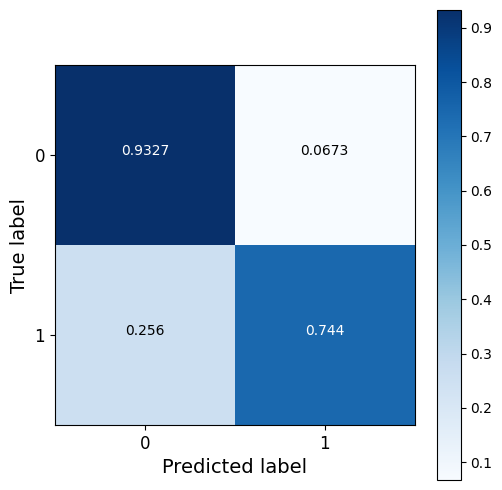

In [72]:
plot_confusion_matrix(confusion_matrix(y_true=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()),'target'], 
                                       y_pred=test_data.loc[(~test_data['binary_pred'].isnull()) & (~test_data['target'].isnull()),'binary_pred']), 
                      classes=[0, 1], normalize=True)